--- 1. Data Splitting Complete ---
Original Training Set Class Distribution:
hospital_expire_flag
0    9477
1    2269
Name: count, dtype: int64

--- 2. Scaling and Imputation Complete ---

--- 3. Augmenting Training Data ---
Generating 3604 samples with SMOTE...


c:\Users\vamsi\anaconda3\envs\rl_med_diag\lib\site-packages\sklearn\base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



Generating 3604 samples with CTGAN (this may take a few minutes)...


c:\Users\vamsi\anaconda3\envs\rl_med_diag\lib\site-packages\sdv\single_table\base.py:163: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

c:\Users\vamsi\anaconda3\envs\rl_med_diag\lib\site-packages\sdv\single_table\base.py:129: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.




Final Augmented Training Set Class Distribution:
hospital_expire_flag
0.0    9477
1.0    9477
Name: count, dtype: int64


C:\Users\vamsi\AppData\Local\Temp\ipykernel_36724\4241406075.py:118: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\vamsi\AppData\Local\Temp\ipykernel_36724\4241406075.py:122: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\vamsi\AppData\Local\Temp\ipykernel_36724\4241406075.py:125: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\vamsi\AppData\Local\Temp\ipykernel_36724\4241406075.py:128: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



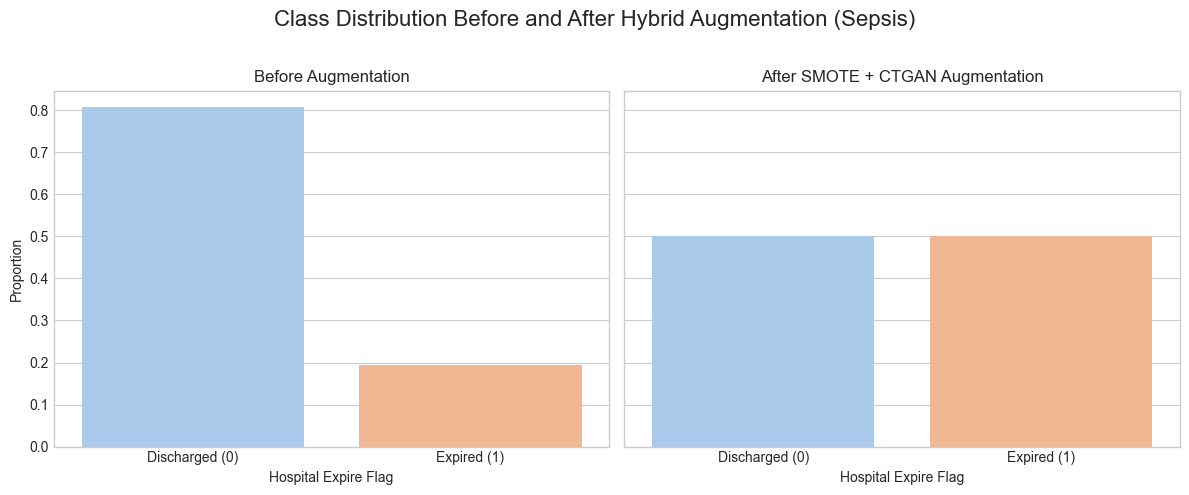

In [3]:
"""
Sepsis Data Augmentation Test

This notebook tests the full data preparation pipeline on the Sepsis dataset.
It loads the preprocessed data, splits it, scales, imputes, and then applies
the hybrid SMOTE & CTGAN augmentation to the training set.

The final output is a verification of the balanced dataset and a bar chart
visualizing the class balance before and after augmentation.
"""
# --- 1. Setup ---
# Install necessary libraries if you haven't already
# !pip install pandas scikit-learn imbalanced-learn sdv matplotlib seaborn

import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

# --- 2. Configuration ---
CONFIG = {
    "INPUT_FILE": "../data/preprocessed/sepsis_feature_matrix.csv",
    "OUTPUT_DIR": Path("../data/processed/sepsis/"),
    "TARGET_COLUMN": "hospital_expire_flag",
    "ID_COLUMNS": ['subject_id', 'hadm_id', 'stay_id'],
    "RANDOM_STATE": 42
}

# --- 3. The Main Pipeline Function ---
def process_and_augment_data(config):
    """
    Runs the entire pipeline: load, split, scale, impute, and augment.
    """
    try:
        df = pd.read_csv(config["INPUT_FILE"])
    except FileNotFoundError:
        print(f"Error: Input file not found at '{config['INPUT_FILE']}'")
        return None, None

    # --- Splitting ---
    X = df.drop(columns=[config["TARGET_COLUMN"]])
    y = df[config["TARGET_COLUMN"]]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=config["RANDOM_STATE"], stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=config["RANDOM_STATE"], stratify=y_temp)
    
    original_distribution = y_train.value_counts(normalize=True)
    print("--- 1. Data Splitting Complete ---")
    print(f"Original Training Set Class Distribution:\n{y_train.value_counts()}")

    # --- Scaling and Imputation ---
    id_cols = [col for col in config["ID_COLUMNS"] if col in X_train.columns]
    feature_cols = [col for col in X_train.columns if col not in id_cols]
    
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    
    X_train_processed = X_train.copy()
    X_train_processed[feature_cols] = scaler.fit_transform(X_train[feature_cols])
    X_train_processed[feature_cols] = imputer.fit_transform(X_train_processed[feature_cols])
    print("\n--- 2. Scaling and Imputation Complete ---")

    # --- Augmentation ---
    print("\n--- 3. Augmenting Training Data ---")
    X_train_features = X_train_processed.drop(columns=id_cols)
    
    train_df_features = pd.concat([X_train_features, y_train.reset_index(drop=True)], axis=1)
    minority_df = train_df_features[train_df_features[config["TARGET_COLUMN"]] == 1]
    majority_df = train_df_features[train_df_features[config["TARGET_COLUMN"]] == 0]
    
    if len(minority_df) == 0:
        print("No minority samples found, skipping augmentation.")
        return None, None
        
    num_to_generate = len(majority_df) - len(minority_df)
    num_from_smote = num_to_generate // 2
    num_from_gan = num_to_generate - num_from_smote
    
    # SMOTE
    print(f"Generating {num_from_smote} samples with SMOTE...")
    smote = SMOTE(sampling_strategy={1: len(minority_df) + num_from_smote}, random_state=config["RANDOM_STATE"])
    X_smote_interim, y_smote_interim = smote.fit_resample(X_train_features, y_train)
    
    # CTGAN
    print(f"Generating {num_from_gan} samples with CTGAN (this may take a few minutes)...")
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=minority_df)
    ctgan = CTGANSynthesizer(metadata, epochs=300, verbose=False)
    ctgan.fit(minority_df)
    gan_generated_df = ctgan.sample(num_rows=num_from_gan)
    
    # Combine
    smote_interim_df = pd.concat([pd.DataFrame(X_smote_interim, columns=X_train_features.columns), pd.Series(y_smote_interim, name=config["TARGET_COLUMN"])], axis=1)
    final_df = pd.concat([smote_interim_df, gan_generated_df], ignore_index=True).sample(frac=1, random_state=config["RANDOM_STATE"])
    
    augmented_distribution = final_df[config["TARGET_COLUMN"]].value_counts(normalize=True)
    print(f"\nFinal Augmented Training Set Class Distribution:\n{final_df[config['TARGET_COLUMN']].value_counts()}")
    
    return original_distribution, augmented_distribution

# --- 4. Run Pipeline and Get Distributions ---
original_dist, augmented_dist = process_and_augment_data(CONFIG)

# --- 5. Visualize Results for Proof ---
if original_dist is not None:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle('Class Distribution Before and After Hybrid Augmentation (Sepsis)', fontsize=16)

    # Before
    sns.barplot(x=original_dist.index, y=original_dist.values, ax=axes[0], palette='pastel')
    axes[0].set_title('Before Augmentation')
    axes[0].set_xlabel('Hospital Expire Flag')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xticklabels(['Discharged (0)', 'Expired (1)'])

    # After
    sns.barplot(x=augmented_dist.index, y=augmented_dist.values, ax=axes[1], palette='pastel')
    axes[1].set_title('After SMOTE + CTGAN Augmentation')
    axes[1].set_xlabel('Hospital Expire Flag')
    axes[1].set_xticklabels(['Discharged (0)', 'Expired (1)'])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

